## Needed Imports

In [1]:
import json
import numpy as np  # Algebra library
import tensorflow as tf  # Tensorflow
import h5py
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

## Define Parameters
Specify the path of the test data and the parameters used for training to load the correct model

### data.json format:
{
    "input_size": [
        X,
        Y,
        Channels
    ],
    "num_classes": Number Of Classes,
    "class_names": [
        "Class 1",
        "Class 2"
    ]
}



In [2]:
# Hardcoded values for training parameters
# Path to .5 file for test data
test_data = r"C:\Users\Michael\Desktop\Model Benchmark\data\CatOrDog\test.h5"

# Set this to none if you will manually input the needed variables
dataJson = r"C:\Users\Michael\Desktop\Model Benchmark\data\CatOrDog\data.json"

checkpoint_path = r"C:\Users\Michael\Desktop\Model Benchmark\tensorboard\Models\CatOrDogStandard16_lr0.0001/my_capsule_network"

# Folder Name Of The Saved Model
# folder_name = "CatOrDogStandard"

# Image dimensions that the model was trained on
# Manually Set This If data.json does not exist, otherwise can leave as None
# input_dimensions = [96, 96, 1]
input_dimensions = None

# Class Names
# Manually Set This If data.json does not exist, otherwise can leave as None
# class_names = ["Cat", "Dog"]
class_names = None

# Number of classes
# Manually Set This If data.json does not exist, otherwise can leave as None
# num_classes = 2
num_classes = None

# Automatically read the input_dimensions, class_names and num_classes from a data.json if it exists
if dataJson is not None:
    with open(dataJson, "r") as f:
        data = json.load(f)

    input_dimensions = data['input_size']
    class_names = data['class_names']
    num_classes = data['num_classes']

    f.close()

# # Batch Size The Model Was Trained With
# batch_size = 16
# 
# # How Many Epochs The Model Was Trained With
# # n_epochs = 20
# 
# # Learning Rate The Model Was Trained With
# lr = 0.0001
# 
# # Load model and tensorboard data to this folder
# folder = folder_name + str(batch_size) + "_lr" + str(lr)
# checkpoint_path = "./tensorboard/Models/" + folder + "/my_capsule_network"
# #learning_rate = learning_rate1

## Load Test Data
This can also be replaced with validation data, there just needs to be corresponding labels

In [3]:
def load_data(path):
    with h5py.File(path, 'r') as f:
        x = f['image'][()]
        y = f['label'][()]
    return np.array(x), np.array(y)


x_test, y_test = load_data(test_data)

# Normalize the image since we don't pass in normalized data but if the data is already normalized we can remove the / 255.
x_test = x_test.reshape((-1, input_dimensions[0], input_dimensions[1], input_dimensions[2])).astype('float32') / 255.
y_test = y_test.astype('float32')

## Loading the Model
The Cell Directly Below Is Template Code That Doesn't Need To Change

The Cell Below This One Can Be Modified To Use The Right Architecture

In [4]:
def predictions(caps_Lminus1, dims_Lminus1, output_Lminus1,
                caps_L, dims_L, batch_size, weight_sharing=False, grid_cells_Lminus1=1, name=None):
    with tf.name_scope(name, default_name="predictions"):
        if weight_sharing == False:
            output_Lminus1 = tf.squeeze(output_Lminus1, axis=[1, 4], name="output_Lminus1")

        init_sigma = 0.1
        W_init = tf.random_normal(shape=(1, caps_Lminus1, caps_L, dims_L, dims_Lminus1),
                                  stddev=init_sigma, dtype=tf.float32, name="W_init")
        W = tf.Variable(W_init, name="W")
        tf.summary.histogram("W", W)

        W_tiled = tf.tile(W, [batch_size, grid_cells_Lminus1, 1, 1, 1], name="W_tiled")
        output_expanded_Lminus1 = tf.expand_dims(output_Lminus1, -1, name="output_expanded_Lminus1")
        output_tile_Lminus1 = tf.expand_dims(output_expanded_Lminus1, 2, name="output_tile_Lminus1")
        output_tiled_Lminus1 = tf.tile(output_tile_Lminus1, [1, 1, caps_L, 1, 1], name="output_tiled_Lminus1")
        predicted_L = tf.matmul(W_tiled, output_tiled_Lminus1, name="predicted_L")

        return predicted_L


def routing(caps_Lminus1, caps_L, batch_size, iterations, predicted_L, name=None):
    with tf.name_scope(name, default_name="routing"):
        raw_weights = tf.zeros([batch_size, caps_Lminus1, caps_L, 1, 1], dtype=np.float32, name="raw_weights")

        for r in range(0, iterations):
            routing_weights = tf.nn.softmax(raw_weights, dim=2, name="routing_weights")
            weighted_predictions = tf.multiply(routing_weights, predicted_L, name="weighted_predictions")
            weighted_sum = tf.reduce_sum(weighted_predictions, axis=(1), keepdims=True, name="weighted_sum")
            output_L = squash(weighted_sum, axis=-2, name="output_L")
            output_tiled_L = tf.tile(output_L, [1, caps_Lminus1, 1, 1, 1], name="output_tiled_L")
            agreement = tf.matmul(predicted_L, output_tiled_L, transpose_a=True, name="agreement")
            raw_weights = tf.add(raw_weights, agreement, name="raw_weights")

        return output_L, routing_weights


def squash(s, axis=-1, epsilon=1e-7, name=None):
    with tf.name_scope(name, default_name="squash"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis, keepdims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector


def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name, default_name="safe_norm"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis, keep_dims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)


X = tf.placeholder(shape=[None, input_dimensions[0], input_dimensions[1], input_dimensions[2]], dtype=tf.float32,
                   name="X")
tf.summary.image('X', X)
y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")

## Adjust This Cell As Needed Depending On The Architecture Used

In [5]:
# Block 1
k = 3
s = 1
x = tf.layers.Conv2D(128, k, s, activation='relu')(X)
x = tf.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

# Block 2
k = 3
s = 1
x = tf.layers.Conv2D(256, k, s, activation='relu')(x)
x = tf.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

# Block 3
k = 7
s = 1
convcaps_dims = 16
convcaps_caps_types = 32
convcaps = tf.layers.Conv2D(convcaps_dims*convcaps_caps_types, k, s, name="convcaps")(x)
tf.summary.histogram("convcaps", convcaps)

convcaps_grid_length = tf.shape(convcaps)[1]
convcaps_grid_width = tf.shape(convcaps)[2]
convcaps_grid_cells = convcaps_grid_length * convcaps_grid_width
convcaps_caps = convcaps_caps_types * convcaps_grid_cells

convcaps_reshape = tf.reshape(convcaps, [-1, convcaps_caps, convcaps_dims], name="convcaps_reshape")
convcaps_output = squash(convcaps_reshape, name="convcaps_output")

batch_size = tf.shape(X)[0]

# If doing more than 1 capsule layer caps1_caps doesn't need to be the num_classes
caps1_caps = num_classes
caps1_dims = 12

caps1_predictions = predictions(convcaps_caps_types, convcaps_dims, convcaps_output,
                                caps1_caps, caps1_dims, batch_size, True, convcaps_grid_cells, "caps1_predictions")

caps1_output, routing1 = routing(convcaps_caps, caps1_caps,
                                 batch_size, 6, caps1_predictions, "routing1")

# You Can Add More Capsule Layers By Doing:
# Adding a second layer:
# -----------------------
# caps2_caps = 8
# caps2_dims = 16
# 
# caps2_predictions = predictions(caps1_caps, caps1_dims, caps1_output, 
#                                 caps2_caps, caps2_dims, batch_size, False, 1, "caps2_predictions")
#                                                                       ^ remains as False
# caps2_output, routing2 = routing(caps1_caps, caps2_caps, batch_size, 9, caps2_predictions, "routing2")
# 
# Adding a third layer:
# -----------------------
# caps3_caps = num_classes
# caps3_dims = 16
# 
# caps3_predictions = predictions(caps2_caps, caps2_dims, caps2_output, 
#                                 caps3_caps, caps3_dims, batch_size, False, 1, "caps3_predictions")
# 
# 
# caps3_output, routing3 = routing(caps2_caps, caps3_caps, batch_size, 9, caps3_predictions, "routing3")
# 
# Then Modify The Variable Below As Needed

# This Line Is Here To Make Using More Capsules Work Without Modifying Variables Below!
final_capsule_output, final_routing_output = caps1_output, routing1

# If more capsule Layers are introduced, the array below needs to be modified as well!
caps_and_routing = [convcaps_output, routing1, caps1_output]

# If Using More Capsules, The Above List Looks Like This:
# caps_and_routing = [convcaps_output, routing1, caps1_output, routing2, caps2_output, ...]

# Find out how many capsule Layers there are
capsule_layers = (len(caps_and_routing) - 1) / 2
print(f"{capsule_layers} Capsule Layer(s)")

# This can stay the same
caps_and_routing_dims = [convcaps_grid_length, convcaps_grid_width, convcaps_caps_types, num_classes]





Instructions for updating:
dim is deprecated, use axis instead
1.0 Capsule Layer(s)


### Rest of the tempalte code

In [6]:
with tf.name_scope(name="accuracy_cell"):
    lengths_temp = safe_norm(final_capsule_output, axis=-2, name="lengths_temp")
    lengths = tf.reshape(lengths_temp, shape=(-1, num_classes), name="lengths")
    lengths_argmax = tf.argmax(lengths, axis=1, name="lengths_argmax")
    y_predictions = lengths_argmax
    correct = tf.equal(y, y_predictions, name="correct")
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    tf.summary.scalar('accuracy', accuracy)

m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

with tf.name_scope(name="loss_cell"):
    T = tf.one_hot(y, depth=caps1_caps, name="T")
    # Compute norm of each capsule in digitcaps
    caps1_output_norm = safe_norm(final_capsule_output, axis=-2, keep_dims=True, name="caps1_output_norm")

    present_error_raw = tf.square(tf.maximum(0., m_plus - caps1_output_norm), name="present_error_raw")
    present_error = tf.reshape(present_error_raw, shape=(-1, caps1_caps), name="present_error")
    # -1 tells reshape to calculate the size of this dimension.

    absent_error_raw = tf.square(tf.maximum(0., caps1_output_norm - m_minus), name="absent_error_raw")
    absent_error = tf.reshape(absent_error_raw, shape=(-1, caps1_caps), name="absent_error")
    # -1 tells reshape to calculate the size of this dimension.

    # Compute Margin Loss
    L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error, name="L")
    loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="loss")
    tf.summary.scalar('loss', loss)

# ### Adam Optimizer
# Initialize adam optimizer to minimize $\texttt{loss}$.
with tf.name_scope(name="train"):
    learning_rate = tf.placeholder(tf.float32, shape=[])
    tf.summary.scalar('learning_rate', learning_rate)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss, name="training_op")

merged_summary = tf.summary.merge_all()
init = tf.global_variables_initializer()
saver = tf.train.Saver()


def visualize_convcaps(caps_and_routing, caps_and_routing_dims, reduce):
    temp_dims = caps_and_routing_dims[0:3] + [1] * (len(caps_and_routing_dims) - 3)
    convcaps_lengths = tf.reshape(safe_norm(caps_and_routing[0], axis=-1), temp_dims)
    temp_dims = [1] * (3) + caps_and_routing_dims[3:len(caps_and_routing_dims)]
    convcaps_lengths_tiled = tf.tile(convcaps_lengths, temp_dims)

    temp_dims = caps_and_routing_dims[0:4] + [1] * (len(caps_and_routing_dims) - 4)
    routing1_reshape = tf.reshape(caps_and_routing[1], temp_dims)
    temp_dims = [1] * (4) + caps_and_routing_dims[4:len(caps_and_routing_dims)]
    routing1_reshape_tiled = tf.tile(routing1_reshape, temp_dims)

    temp_dims = [1, 1, 1, caps_and_routing_dims[3]] + [1] * (len(caps_and_routing_dims) - 4)
    caps1_lengths = tf.reshape(safe_norm(caps_and_routing[2], axis=-2), temp_dims)
    temp_dims = caps_and_routing_dims[0:3] + [1] + caps_and_routing_dims[4:len(caps_and_routing_dims)]
    caps1_lengths_tiled = tf.tile(caps1_lengths, temp_dims)

    temp1 = tf.square(tf.multiply(routing1_reshape_tiled, caps1_lengths_tiled))

    temp_matrices = []
    index = 0
    for i in range(4, len(caps_and_routing_dims)):
        temp_dims = [1] * (i - 1) + caps_and_routing_dims[i - 1:i + 1] + [1] * (len(caps_and_routing_dims) - i - 1)
        routing_reshape = tf.reshape(caps_and_routing[3 + index], temp_dims)
        temp_dims = caps_and_routing_dims[0:i - 1] + [1] * (2) + caps_and_routing_dims[
                                                                 i + 1:len(caps_and_routing_dims)]
        routing_reshape_tiled = tf.tile(routing_reshape, temp_dims)

        temp_dims = [1] * len(caps_and_routing_dims)
        temp_dims[i] = caps_and_routing_dims[i]
        caps_lengths = tf.reshape(safe_norm(caps_and_routing[3 + index + 1], axis=-2), temp_dims)
        temp_dims = caps_and_routing_dims.copy()
        temp_dims[i] = 1
        caps_lengths_tiled = tf.tile(caps_lengths, temp_dims)

        temp = tf.square(tf.multiply(routing_reshape_tiled, caps_lengths_tiled))
        temp_matrices.append(temp)

        index = index + 2

    all_paths = tf.multiply(convcaps_lengths_tiled, temp1)
    for temp_matrice in temp_matrices:
        all_paths = tf.multiply(all_paths, temp_matrice)

    normalizing_factor = np.prod(caps_and_routing_dims[2:len(caps_and_routing_dims)])
    all_paths_average = tf.reduce_sum(all_paths, axis=reduce) / normalizing_factor

    return all_paths_average

Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





## Specify Any Parameters For What Data To Use
Only need to run the cells below for a new dataset, otherwise simply load the saved npy file below

## Load the npy file if it already exists

In [27]:
loaded_array = np.load('rpv-outputs.npy', allow_pickle=True)

## For a new dataset

In [7]:
# Will Only Use Predictions With A Confidence Above 80%
accuracyThreshold = 0.8

# Will Use Only Correct Examples
onlyCorrect = True

# Starting Index
startIndex = 0

# How Many Images To Sample Given The Requirements
# If This Is None, It will Use All Possible, Otherwise it will take x consecutive images
# amountOfSamples = 5
amountOfSamples = None

# Specify Which Axis To Reduce
# For Simplicity This Views All Capsule Layers But Can Be Modified Like So:
# reduce = [2] <-- only first capsule layer
# reduce = [3] <-- only second capsule layer
# reduce = [2,3] <-- only first and second capsule layer
# reduce = [3,4] <-- only second and third capsule layer
reduce = list(range(2, 2 + int(capsule_layers)))
print(reduce)

[2]


## Generate and Save RPV Outputs To View Outputs On Different Runtimes

In [8]:
# Initialize variables and lists
results = []
correct_samples_collected = 0

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    i = startIndex
    while (amountOfSamples is None or correct_samples_collected < amountOfSamples) and i < len(x_test):
        print(f"{i} / {len(x_test)}")

        # Run the session to get outputs
        out = sess.run([visualize_convcaps(caps_and_routing, caps_and_routing_dims, reduce), y_predictions, lengths],
                       feed_dict={
                           X: x_test[i].reshape([-1, input_dimensions[0], input_dimensions[1], input_dimensions[2]]),
                           y: [y_test[i]]})

        feature_map = out[0]  # Keep the (x, y, num_class) shape
        prediction = out[1][0]  # Predicted value
        ground_truth = y_test[i]  # Actual label
        confidenceScore = out[2].flatten().tolist()  # Confidence scores
        image_index = i  # Index Of Image If It Needs To Be Referenced Elsewhere

        # Check if the prediction meets the criteria
        correct = (prediction == ground_truth)

        # Check the confidence score of the predicted class
        confidence = confidenceScore[prediction]

        if (confidence >= accuracyThreshold) and (not onlyCorrect or correct):
            # Store the feature map, prediction, real value, confidence score and image index as a tuple
            results.append((feature_map, prediction, ground_truth, confidenceScore, image_index))
            correct_samples_collected += 1
            print(f"Saving {i} To Output")

        # Move to the next index
        i += 1

# Optionally, convert the list to a structured array if you want to access by field name
# dtype = [('feature_map', np.float32, (45, 45, 2)), ('prediction', np.float32), ('ground_truth', np.float32),
#          ('confidence_score', np.float32, (2,)), ('image_index', np.int32)]

loaded_array = np.array(results)

# Save the results
# Option To Save Array
np.save('rpv-outputs.npy', loaded_array)


INFO:tensorflow:Restoring parameters from C:\Users\Michael\Desktop\Model Benchmark\tensorboard\Models\CatOrDogStandard16_lr0.0001/my_capsule_network
0 / 2492
Saving 0 To Output
1 / 2492
2 / 2492
Saving 2 To Output
3 / 2492
4 / 2492
5 / 2492
Saving 5 To Output
6 / 2492
Saving 6 To Output
7 / 2492
8 / 2492
Saving 8 To Output
9 / 2492
Saving 9 To Output
10 / 2492
Saving 10 To Output
11 / 2492
Saving 11 To Output
12 / 2492
13 / 2492
Saving 13 To Output
14 / 2492
15 / 2492
16 / 2492
Saving 16 To Output
17 / 2492
Saving 17 To Output
18 / 2492
19 / 2492
Saving 19 To Output
20 / 2492
21 / 2492
Saving 21 To Output
22 / 2492
23 / 2492
24 / 2492
25 / 2492
26 / 2492
27 / 2492
28 / 2492
29 / 2492
Saving 29 To Output
30 / 2492
31 / 2492
32 / 2492
33 / 2492
34 / 2492
Saving 34 To Output
35 / 2492
36 / 2492
37 / 2492
Saving 37 To Output
38 / 2492
Saving 38 To Output
39 / 2492
Saving 39 To Output
40 / 2492
Saving 40 To Output
41 / 2492
42 / 2492
Saving 42 To Output
43 / 2492
Saving 43 To Output
44 / 2

## Creating a violin plot of the data distribution to threshold the feature map

Finding the min and max of the data

In [28]:
from sklearn.preprocessing import normalize

# Initialize lists to store the statistics
max_values_correct = []
min_values_correct = []
avg_values_correct = []

max_values_incorrect = []
min_values_incorrect = []
avg_values_incorrect = []

# Iterate through all the predictions
for prediction in loaded_array:
    feature_map, correct_class = prediction[0], int(prediction[1])

    # Flatten the correct class feature map
    flattened_correct = feature_map[:, :, correct_class].flatten()

    # Normalize from 0-1?
    # flattened_correct = normalize(flattened_correct, norm='max', axis=0)

    # Flatten all incorrect class feature maps (excluding the correct class)
    # Removes the correct prediction and flattens all the incorrect classes into a single array
    flattened_incorrect = np.delete(feature_map, correct_class, axis=2).flatten()

    # Normalize from 0-1?
    # flattened_incorrect = normalize(flattened_incorrect, norm='max', axis=0)

    # Calculate and store the statistics for correct class
    max_values_correct.append(np.max(flattened_correct))
    min_values_correct.append(np.min(flattened_correct))
    avg_values_correct.append(np.mean(flattened_correct))

    # Calculate and store the statistics for incorrect classes
    max_values_incorrect.append(np.max(flattened_incorrect))
    min_values_incorrect.append(np.min(flattened_incorrect))
    avg_values_incorrect.append(np.mean(flattened_incorrect))

# Convert lists to NumPy arrays for efficient numerical operations
max_values_correct = np.array(max_values_correct)
min_values_correct = np.array(min_values_correct)
avg_values_correct = np.array(avg_values_correct)

max_values_incorrect = np.array(max_values_incorrect)
min_values_incorrect = np.array(min_values_incorrect)
avg_values_incorrect = np.array(avg_values_incorrect)

### Plotting the data

Mean values:
Correct Capsule = 0.0006975052529014647
Incorrect Capsule = 4.068738780915737e-05



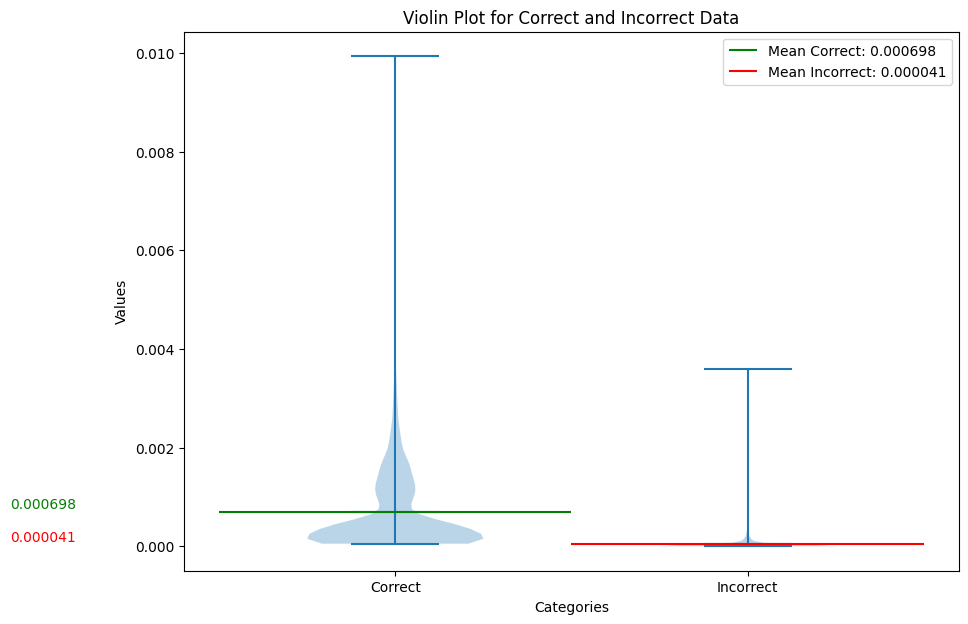

In [29]:
correctVals = np.concatenate((min_values_correct, max_values_correct, avg_values_correct))
incorrectVals = np.concatenate((min_values_incorrect, max_values_incorrect, avg_values_incorrect))

# Data for plotting
data = [correctVals, incorrectVals]
labels = ['Correct', 'Incorrect']

# Combine the data into one list
data = [correctVals, incorrectVals]

# Calculate means
means = [np.mean(correctVals), np.mean(incorrectVals)]
print(f"Mean values:\n"
      f"Correct Capsule = {means[0]}\n"
      f"Incorrect Capsule = {means[1]}\n")

fig, ax = plt.subplots(figsize=(10, 7))

# Create the violin plot
plt.violinplot(data, showmeans=True, showmedians=False)

# Add x-axis labels
plt.xticks([1, 2], ['Correct', 'Incorrect'])

# Title and labels
plt.title('Violin Plot for Correct and Incorrect Data')
plt.ylabel('Values')
plt.xlabel('Categories')

# Add horizontal lines for means
ax.hlines(y=means[0], xmin=0.5, xmax=1.5, colors='green', linestyles='solid', label=f'Mean Correct: {means[0]:.6f}')
ax.hlines(y=means[1], xmin=1.5, xmax=2.5, colors='red', linestyles='solid', label=f'Mean Incorrect: {means[1]:.6f}')

# Annotate means on the plot
plt.text(0, means[0], f'{means[0]:.6f}', ha='center', va='bottom', color='green')
plt.text(0, means[1], f'{means[1]:.6f}', ha='center', va='bottom', color='red')

# Add legend
plt.legend()

# Show plot
plt.show()

## Hide Irrelevant parts of the image

INFO:tensorflow:Restoring parameters from C:\Users\Michael\Desktop\Model Benchmark\tensorboard\Models\CatOrDogStandard16_lr0.0001/my_capsule_network
[[0.00036569 0.0003191  0.00025937 0.00020249 0.00026128 0.00033923
  0.00032063 0.00040248 0.00029234 0.00036072 0.00045125 0.00037128
  0.00027022 0.00025762 0.00025328 0.00021154]
 [0.00058407 0.00048376 0.00037248 0.00031482 0.0005456  0.00081073
  0.00050833 0.00053308 0.00045455 0.00045043 0.00051643 0.00046123
  0.00036335 0.00033084 0.00032364 0.00025343]
 [0.00046005 0.00034577 0.00027843 0.00059384 0.00107281 0.00144688
  0.00080039 0.00069966 0.00059608 0.00057904 0.00066387 0.00062708
  0.0005578  0.00052627 0.00043566 0.00027686]
 [0.00050239 0.00053792 0.00038179 0.00056547 0.00110497 0.00129959
  0.00081496 0.00078511 0.0005984  0.00053296 0.00062887 0.00069494
  0.00071604 0.0006059  0.00055901 0.0003234 ]
 [0.00044353 0.00052383 0.00038428 0.0003712  0.00066385 0.00076986
  0.00055667 0.00071938 0.00050884 0.00052592 0.000

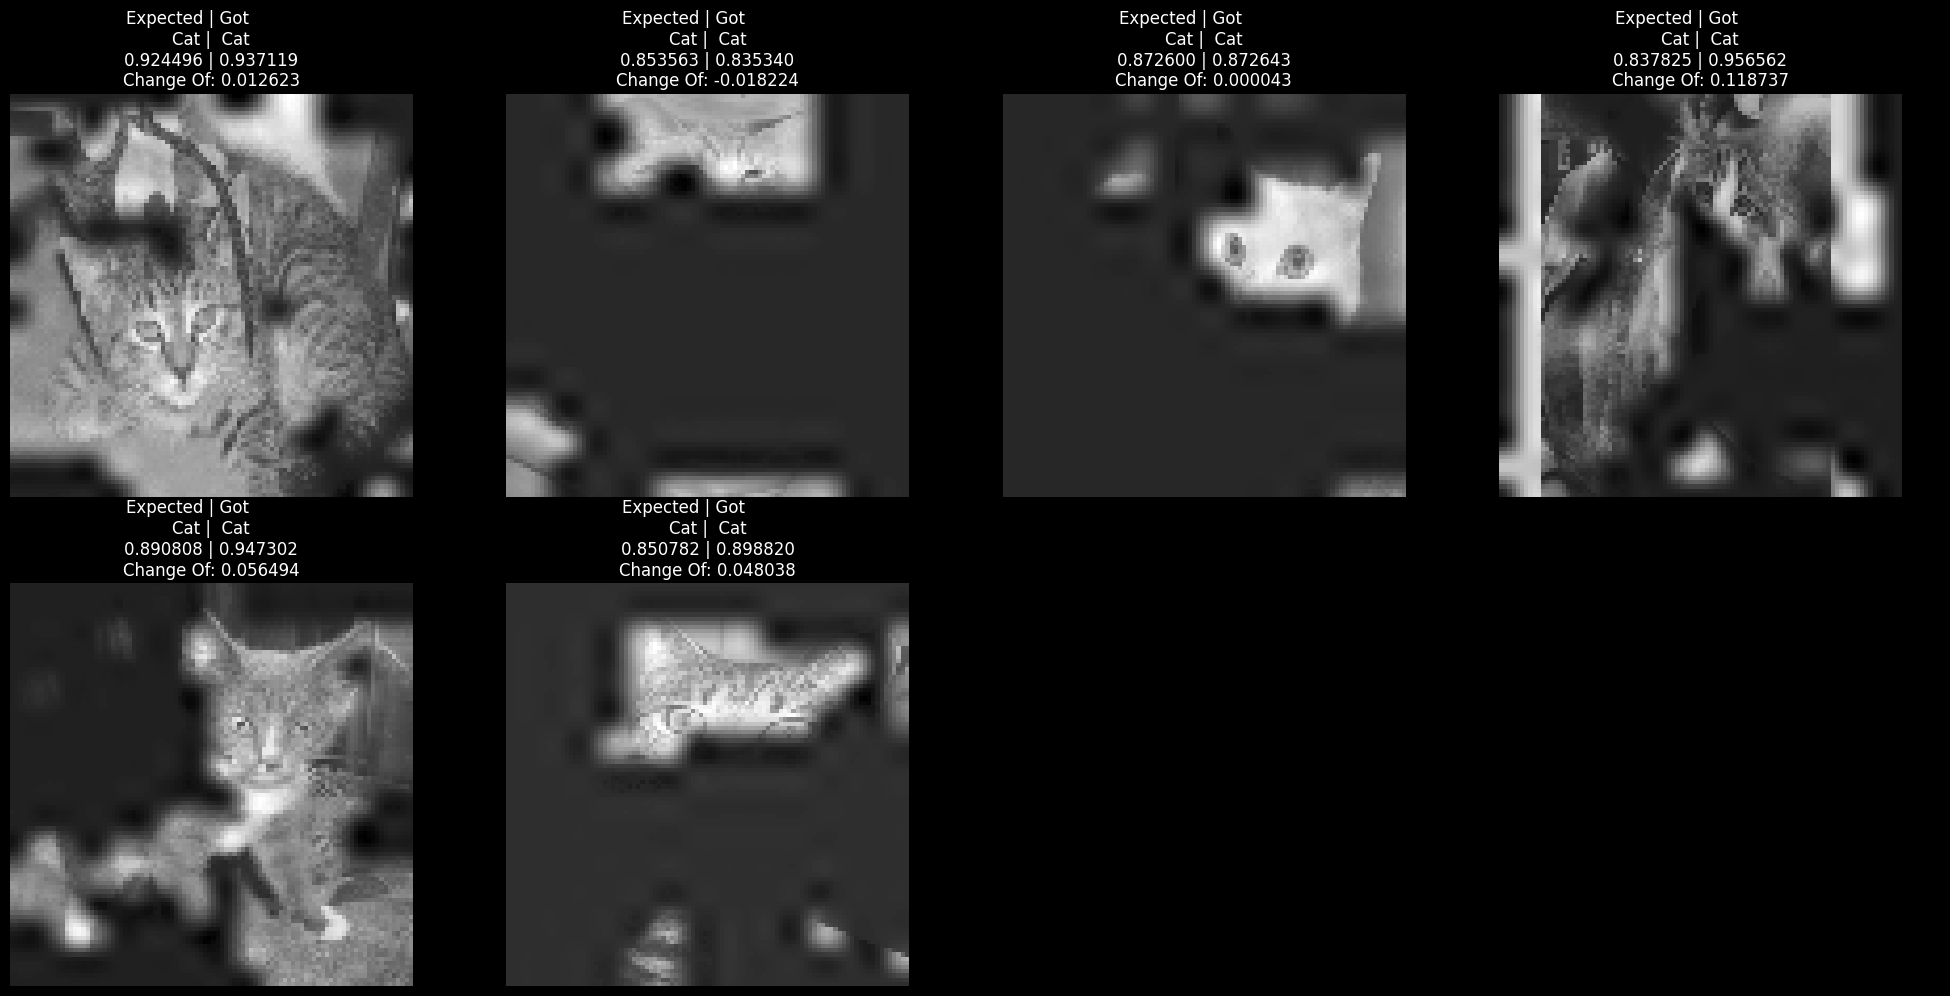

In [35]:
# Evalaute On The Range Below
startingIndex = 0
endIndex = 6
backColour = 'black'
textColour = 'white'
alphaValue = 0.75
defaultColourMap = 'turbo'
decimalPrecision = 6

properMeans = (means[0] + means[1]) / 2.0
# properMeans = means[1]
#properMeans = 0.007

totalChange = 0.0

# Number of images to plot
num_images = endIndex - startingIndex

# Determine the grid size for subplots (e.g., 2x2 grid for 4 images)
num_cols = 4
num_rows = (num_images + num_cols - 1) // num_cols

# Create a figure with the desired number of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10), facecolor=backColour)

# Flatten axes array for easy indexing
axes = axes.flatten()

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    for i in range(startingIndex, endIndex):
        prediction = loaded_array[i][1]
        ground_truth = loaded_array[i][2]
        featureMap = np.copy(loaded_array[i][0][:, :, int(ground_truth)])
        print(featureMap)
        
        # Apply The Threshold
        featureMap[featureMap < properMeans] = 0
        featureMap[featureMap > 0] = 1
        
        print(featureMap)
        
        confidenceScore = loaded_array[i][3][int(ground_truth)]
        image_index = loaded_array[i][4]

        baseImage = x_test[image_index]

        # Resize the feature map to match the base image dimensions
        scale_factor = (input_dimensions[0] / featureMap.shape[0], input_dimensions[1] / featureMap.shape[1])
        #print(featureMap)
        
        resized_featureMap = zoom(featureMap, scale_factor)
        
        # New Prediction With Irrelevant Areas Hidden
        # Repredict
        # Mask The Irrelevent Areas With 0's, the multiplying should be good enough since matplotlib will take care of rescaling?
        normalized_image = overlayedImage = resized_featureMap.reshape(input_dimensions[0], input_dimensions[1],input_dimensions[2]) * baseImage
        
        # Renormalize The Image So It's Between 0-1 like the model expects
        # normalized_image = (overlayedImage - np.min(overlayedImage)) / (np.max(overlayedImage) - np.min(overlayedImage))

        # Run the session to get outputs
        out = sess.run([visualize_convcaps(caps_and_routing, caps_and_routing_dims, reduce), y_predictions, lengths],
                       feed_dict={
                           X: normalized_image.reshape(1, input_dimensions[0], input_dimensions[1],
                                                       input_dimensions[2]),
                           y: [y_test[image_index]]})

        prediction2 = out[1][0]  # Predicted value
        ground_truth2 = y_test[image_index]  # Actual label
        confidenceScore2 = out[2].flatten().tolist()[int(ground_truth2)]  # Confidence scores
        featureMap2 = out[0][:, :, int(ground_truth2)]

        resized_featureMap2 = zoom(featureMap2, scale_factor)

        # Plot the base image in the corresponding subplot
        axes[i - startingIndex].imshow(normalized_image, cmap='gray')

        # Overlay the resized feature map with some transparency
        axes[i - startingIndex].imshow(resized_featureMap2, cmap=defaultColourMap, alpha=0)

        # Set title for each subplot
        axes[i - startingIndex].set_title(
            f"Expected | Got         \n"
            f"{class_names[int(ground_truth2)]} |  {class_names[int(prediction2)]}\n"
            f"{confidenceScore:.{decimalPrecision}f} | {confidenceScore2:.{decimalPrecision}f}\n"
            f"Change Of: {(confidenceScore2 - confidenceScore):.{decimalPrecision}f}",
            fontsize=12, color=textColour
        )
        
        totalChange += (confidenceScore2 - confidenceScore)

        #.set_title(f'Class: {class_names[int(ground_truth)]}\nConfidence Change: {confidenceScore-:.{decimalPrecision}f}', fontsize=12, color=textColour)
        axes[i - startingIndex].axis('off')

# Hide any unused subplots
for j in range(num_images, num_rows * num_cols):
    axes[j].axis('off')

# Adjust spacing between plots
#plt.subplots_adjust(hspace=0.3, wspace=0.3)  # Adjust hspace and wspace values as needed

print(f"Average Confidence Change Of: {totalChange/(endIndex-startingIndex)}")

plt.tight_layout()

# Display all plots
plt.show()
